In [2]:
!pip install torch torchvision

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [34]:
from PIL import Image
import numpy as np

filename = "Test_Sample/pass.png"
image = Image.open(filename).convert('L')

from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

image_3ch = Image.merge('RGB', (image, image, image))

prompts = ["bigger centric circle", "black color", "squares", "mid pixel of centric square, 1px wide"]

inputs = processor(text=prompts, images=[image_3ch] * len(prompts), padding="max_length", return_tensors="pt")

import torch

# predict
with torch.no_grad():
    outputs = model(**inputs)

preds = outputs.logits

# Convert predictions to PIL images
segmentation_masks = []
for i in range(len(prompts)):
    # Convert tensor to numpy array and scale to 0-255
    mask = torch.sigmoid(preds[i]).numpy()
    mask = (mask * 255).astype(np.uint8)
    # Convert to PIL Image
    mask_image = Image.fromarray(mask)
    segmentation_masks.append(mask_image)

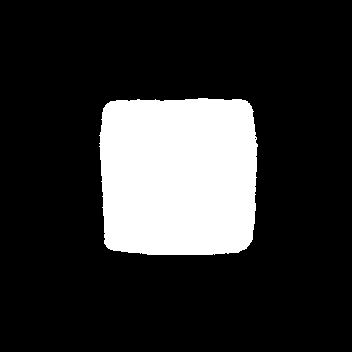

In [49]:

im = segmentation_masks[2]
bw_img = im.convert('L')

THRESHOLD = 70
for x in range(bw_img.width):
    for y in range(bw_img.height):
        if bw_img.getpixel((x, y)) < THRESHOLD:
            bw_img.putpixel((x, y), 0)
        else:
            bw_img.putpixel((x, y), 255)
            
bw_img

In [48]:

im = segmentation_masks[1]
bw_img = im.convert('L')

THRESHOLD = 70
for x in range(bw_img.width):
    for y in range(bw_img.height):
        if bw_img.getpixel((x, y)) < THRESHOLD:
            bw_img.putpixel((x, y), 0)
        else:
            bw_img.putpixel((x, y), 255)
            
bw_img

# Initialize the boundary values
left_most = bw_img.width  # Start with maximum possible value
right_most = 0           # Start with minimum possible value
top_most = bw_img.height # Start with maximum possible value
bottom_most = 0         # Start with minimum possible value

# Scan through all pixels
for x in range(bw_img.width):
    for y in range(bw_img.height):
        if bw_img.getpixel((x, y)) == 255:  # If we find a white pixel
            # Update boundaries
            left_most = min(left_most, x)
            right_most = max(right_most, x)
            top_most = min(top_most, y)
            bottom_most = max(bottom_most, y)

print(f"Left most white pixel: x = {left_most}")
print(f"Right most white pixel: x = {right_most}")
print(f"Top most white pixel: y = {top_most}")
print(f"Bottom most white pixel: y = {bottom_most}")

# Calculate center coordinates
center_x = (left_most + right_most) // 2
center_y = (top_most + bottom_most) // 2

print(f"Center point: x = {center_x}, y = {center_y}")

Left most white pixel: x = 151
Right most white pixel: x = 201
Top most white pixel: y = 148
Bottom most white pixel: y = 204
Center point: x = 176, y = 176


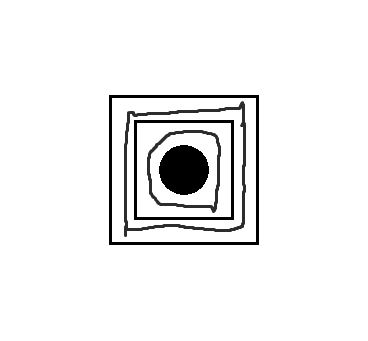

In [47]:
image